In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torchfcn
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, scale=(0.50, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.NEAREST):
        self.size = (size, size)
        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """

        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(*scale) * area
            aspect_ratio = random.uniform(*ratio)

            w = int(round(np.sqrt(target_area * aspect_ratio)))
            h = int(round(np.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback
        w = min(img.size[0], img.size[1])
        i = (img.size[1] - w) // 2
        j = (img.size[0] - w) // 2
        return i, j, w, w

    def __call__(self, img, gt):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.
        Returns:
            PIL Image: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return transforms.functional.resized_crop(img, i, j, h, w, self.size, self.interpolation), \
               transforms.functional.resized_crop(gt, i, j, h, w, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = _pil_interpolation_to_str[self.interpolation]
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(round(self.scale, 4))
        format_string += ', ratio={0}'.format(round(self.ratio, 4))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string


In [3]:
def onehot(data, n):
    buf = np.zeros(data.shape + (n, ), np.float32)
    nmsk = np.arange(data.size)*n + data.ravel()
    buf.ravel()[nmsk-1] = 1
    buf = buf.transpose(2,0,1)
    return buf

In [4]:
class Bags(Dataset):
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
 
    def __init__(self, root, split, preprocess=None):
        assert split in ['train', 'val']
        
        self.samples = open(os.path.join(root, 'imagesets', split + '.txt')).readlines()
        self.samples = [number.strip() for number in self.samples]
        self.root = root
        self.preprocess = preprocess
        
    def __getitem__(self, index):
        img_path = os.path.join(self.root, 'JPEGImages', self.samples[index] + '.jpg')
        gt_path = os.path.join(self.root, 'segmentation_mask', self.samples[index] + '.png')
        img = Image.open(img_path)
        gt = Image.open(gt_path)
        if self.preprocess is not None:
            img, gt = self.preprocess(img, gt)
        img = np.array(img)
        img = self.transform(img)
        gt = np.array(gt, dtype=np.long)
        gt = onehot(gt, 2)
        return img, gt
    
    def transform(self, img):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float32)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1)
        return img
    
    def untransform(self, img):
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        return img

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        return fmt_str


In [5]:
train_set = Bags(root='bags_data',
                 split='train',
                 preprocess=RandomResizedCrop(256))

val_set = Bags(root='bags_data',
               split='val')

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=8)


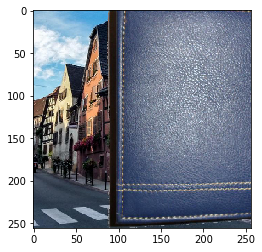

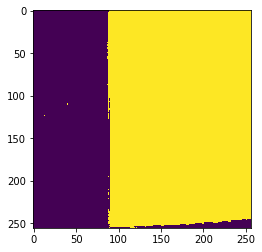

In [6]:
sample = train_set[0]
plt.imshow(train_set.untransform(sample[0]))
plt.show()
plt.imshow(sample[1][0])
plt.show()


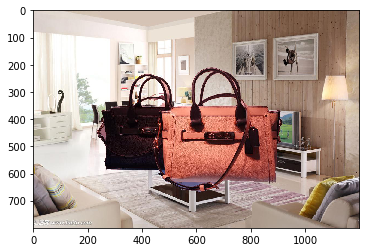

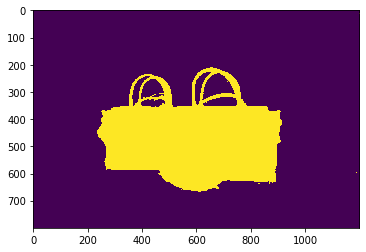

In [7]:
sample = val_set[0]
plt.imshow(val_set.untransform(sample[0]))
plt.show()
plt.imshow(sample[1][0])
plt.show()


In [8]:
model = torchfcn.models.FCN8sAtOnce(n_class=2)

vgg16 = torchfcn.models.VGG16(pretrained=True)
model.copy_params_from_vgg16(vgg16)

model.cuda()

activation = torch.nn.Sigmoid()
criterion = torch.nn.BCELoss().cuda()
# activation = torch.nn.LogSoftmax(dim=1)
# criterion = torch.nn.NLLLoss()

[/home/akoelsch/data/models/pytorch/vgg16_from_caffe.pth] Checking md5 (aa75b158f4181e7f6230029eb96c1b13)


In [9]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        torchfcn.models.FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))


lr = 1.0e-6
optimizer = torch.optim.SGD(
    [
        {'params': get_parameters(model, bias=False)},
        {'params': get_parameters(model, bias=True),
         'lr': lr * 2, 'weight_decay': 0},
    ],
    lr=lr,
    momentum=0.99,
    weight_decay=0.0005
)


In [10]:
def miou(gt, prediction):
    gt.shape = (len(gt) , -1)
    prediction.shape = (len(prediction), -1)
    result = []
    for i in range(len(gt)):
        mean_iou = 0
        for j in range(2):
            intersection = np.intersect1d(np.where(gt[i]==j)[0], np.where(prediction[i]==j)[0]).sum()
            union = np.union1d(np.where(gt[i]==j)[0], np.where(prediction[i]==j)[0]).sum()
            iou = intersection/union
            mean_iou += iou
        mean_iou /= 2
        result.append(mean_iou)
    return result

In [11]:
def train_epoch(model, optimizer, data_loader):
    model.train()
    iterator = tqdm.tqdm_notebook(data_loader, leave=False, desc='training progress')
    epoch_loss = 0
    mious = []
    for img, gt in iterator:
        optimizer.zero_grad()
        img = img.cuda()
        gt = gt.cuda()
        prediction = model(img)
        prediction = activation(prediction)
        loss = criterion(prediction, gt)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
        np_gt = gt[:, 1].cpu().numpy()
        np_prediction = prediction.data.max(1)[1].cpu().numpy()[:]
        mious.extend(miou(np_gt, np_prediction))
        iterator.set_postfix(loss='{:.3f}'.format(loss))
    return epoch_loss/len(data_loader), mious

In [12]:
def eval_epoch(model, data_loader):
    model.eval()
    iterator = tqdm.tqdm_notebook(data_loader, leave=False, desc='evaluation progress')
    epoch_loss = 0
    mious = []
    with torch.no_grad():
        for img, gt in iterator:
            img = img.cuda()
            gt = gt.cuda()
            prediction = model(img)
            prediction = activation(prediction)
            loss = criterion(prediction, gt)
            epoch_loss += loss
            np_gt = gt[:, 1].cpu().numpy()
            np_prediction = prediction.data.max(1)[1].cpu().numpy()[:]
            mious.extend(miou(np_gt, np_prediction))
            iterator.set_postfix(loss='{:.3f}'.format(loss))
    return epoch_loss/len(data_loader), mious

In [13]:
loss_train, loss_val, mious_train, mious_val = [], [], [], []


In [14]:
for epoch in tqdm.tqdm_notebook(range(100)):
    loss, mious = train_epoch(model, optimizer, train_loader)
    loss_train.append(loss)
    mious_train.append(np.nanmean(mious))
    torch.cuda.empty_cache()
    
    loss, mious = eval_epoch(model, val_loader)
    loss_val.append(loss)
    mious_val.append(np.nanmean(mious))
    torch.cuda.empty_cache()
    

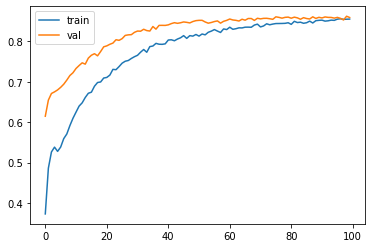

In [15]:
plt.plot(mious_train, label="train")
plt.plot(mious_val, label="val")
plt.legend()
plt.show()

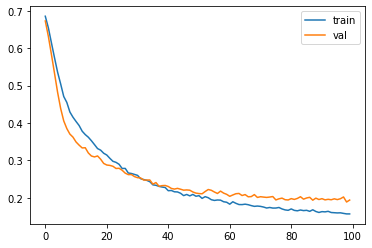

In [16]:
plt.plot(loss_train, label="train")
plt.plot(loss_val, label="val")
plt.legend()
plt.show()

In [17]:
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, "segmentation.pth"
)

In [18]:
img, gt = next(iter(val_loader))
img = img.cuda()
gt = gt.cuda()

prediction = model(img)
prediction = activation(prediction)
np_prediction = prediction.data.max(1)[1].cpu().numpy()[:]


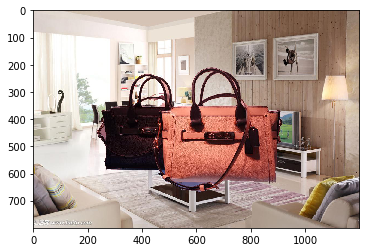

In [19]:
plt.imshow(val_set.untransform(img[0].cpu().numpy()))
plt.show()

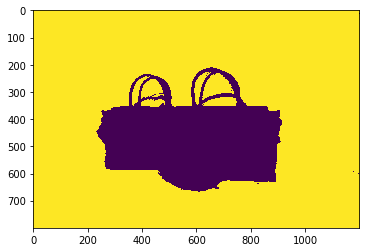

In [20]:
plt.imshow(gt[0][1].cpu().numpy())
plt.show()

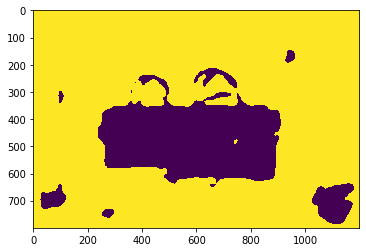

In [21]:
plt.imshow(np_prediction[0])
plt.show()